Xem giúp t các mô hình ML này cái :)))
* cách chia train-test có ghi ở bên dưới r (có thể điều chỉnh tuỳ ý nhá)
* mới có mẫu cho chunks thôi, tương tự cho full audio
* chạy giúp t các mô hình RF, Catboost, SVM, LightGBM, (xem các model trong một số paper để cài đặt lại nha).
* dùng các feature trong
** Senior Thesis/Workspace/recognition/ml_model/chunks
** Senior Thesis/Workspace/recognition/ml_model/full_audio

Features

* Need to split train - val - test (8:1:1)
* No chunks from one target are split to different sets.
* Label distribution must be 8:1:1
* Note: label 0: healthy, label 1: covid-19

### Set up

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install catboost

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import sys

import lightgbm as lgb
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier as rf 
from sklearn.model_selection import GridSearchCV

from IPython.display import clear_output, Audio
import IPython.display as ipd
import os
import numpy as np
import shutil
import pandas as pd
import logging
import warnings

logger = logging.getLogger('ML MODEL')
logger.setLevel(logging.DEBUG)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)
pd.set_option('display.max_colwidth', None)

warnings.filterwarnings("ignore")

clear_output()

##Raw/Chunk

In [ ]:
root = '/content/gdrive/MyDrive/Senior Thesis/Workspace/recognition/ml_model/chunks'
#root = '/content/gdrive/MyDrive/Senior Thesis/Workspace/recognition/ml_model/full_audio'

mel_aicovidvn = os.path.join(root, 'melspectrogram_aicovidvn_features.csv')
mel_coswara = os.path.join(root, 'melspectrogram_coswara_features.csv')
mel_coughvid = os.path.join(root, 'melspectrogram_coughvid_features.csv')

mfcc_13_coswara = os.path.join(root, 'mfcc_13_coswara_features.csv')
mfcc_26_coswara = os.path.join(root, 'mfcc_26_coswara_features.csv')
mfcc_39_coswara = os.path.join(root, 'mfcc_39_coswara_features.csv')

mfcc_13_coughvid = os.path.join(root, 'mfcc_13_coughvid_features.csv')
mfcc_26_coughvid = os.path.join(root, 'mfcc_26_coughvid_features.csv')
mfcc_39_coughvid = os.path.join(root, 'mfcc_39_coughvid_features.csv')

### Coswara

In [ ]:
def data_split(label0, label1):
  p180 = int(len(label1)*80/100)
  p190 = int(len(label1)*90/100)
  p080 = int(len(label0)*80/100)
  p090 = int(len(label0)*90/100)
  
  train = pd.concat([label0[:p080], label1[:p180]], ignore_index=True)
  val = pd.concat([label0[p080:p090], label1[p180:p190]], ignore_index=True)
  test = pd.concat([label0[p090:], label1[p190:]], ignore_index=True)

  train = train.sample(frac=1).reset_index(drop=True)
  val = val.sample(frac=1).reset_index(drop=True)
  test = test.sample(frac=1).reset_index(drop=True)

  return train, val, test

#### Melspectrogram

In [ ]:
mel_coswara_df = pd.read_csv(mel_coswara)
mel_coswara_df.label = mel_coswara_df.label.map({
    'healthy': 0,
    'positive_mild': 1,
    'no_resp_illness_exposed': 1,
    'resp_illness_not_identified': 0,
    'positive_moderate': 1,
    'recovered_full': 0,
    'positive_asymp': 1
})
label0 = mel_coswara_df[mel_coswara_df['label']==0].copy().reset_index(drop=True)
label1 = mel_coswara_df[mel_coswara_df['label']==1].copy().reset_index(drop=True)

In [ ]:
len(label0), len(label1)

(16871, 6007)

In [ ]:
int(len(label1)*80/100) + (len(label1)-int(len(label1)*80/100))

6007

In [ ]:
train_cos_mel, val_cos_mel, test_cos_mel = data_split(label0, label1)

In [ ]:
train_cos_mel.shape, val_cos_mel.shape, test_cos_mel.shape

((18301, 225), (2288, 225), (2289, 225))

In [ ]:
train_cos_mel.label.value_counts(), val_cos_mel.label.value_counts(), test_cos_mel.label.value_counts(),

(0    13496
 1     4805
 Name: label, dtype: int64, 0    1687
 1     601
 Name: label, dtype: int64, 0    1688
 1     601
 Name: label, dtype: int64)

In [ ]:
X_train_cos_mel = train_cos_mel.iloc[:, :-1].values
y_train_cos_mel = train_cos_mel.iloc[:, -1].values
X_val_cos_mel = val_cos_mel.iloc[:, :-1].values
y_val_cos_mel = val_cos_mel.iloc[:, -1].values
X_test_cos_mel = test_cos_mel.iloc[:, :-1].values
y_test_cos_mel = test_cos_mel.iloc[:, -1].values

#### MFCC

##### 13

In [ ]:
mfcc_coswara_df = pd.read_csv(mfcc_13_coswara)
mfcc_coswara_df.label = mfcc_coswara_df.label.map({
    'healthy': 0,
    'positive_mild': 1,
    'no_resp_illness_exposed': 1,
    'resp_illness_not_identified': 0,
    'positive_moderate': 1,
    'recovered_full': 0,
    'positive_asymp': 1
})
label0 = mfcc_coswara_df[mfcc_coswara_df['label']==0].copy().reset_index(drop=True)
label1 = mfcc_coswara_df[mfcc_coswara_df['label']==1].copy().reset_index(drop=True)
train_cos_mfcc, val_cos_mfcc, test_cos_mfcc = data_split(label0, label1)
X_train_cos_mfcc_13 = train_cos_mfcc.iloc[:, :-1].values
y_train_cos_mfcc_13 = train_cos_mfcc.iloc[:, -1].values
X_val_cos_mfcc_13 = val_cos_mfcc.iloc[:, :-1].values
y_val_cos_mfcc_13 = val_cos_mfcc.iloc[:, -1].values
X_test_cos_mfcc_13 = test_cos_mfcc.iloc[:, :-1].values
y_test_cos_mfcc_13 = test_cos_mfcc.iloc[:, -1].values

##### 26

In [ ]:
mfcc_coswara_df = pd.read_csv(mfcc_26_coswara)
mfcc_coswara_df.label = mfcc_coswara_df.label.map({
    'healthy': 0,
    'positive_mild': 1,
    'no_resp_illness_exposed': 1,
    'resp_illness_not_identified': 0,
    'positive_moderate': 1,
    'recovered_full': 0,
    'positive_asymp': 1
})
label0 = mfcc_coswara_df[mfcc_coswara_df['label']==0].copy().reset_index(drop=True)
label1 = mfcc_coswara_df[mfcc_coswara_df['label']==1].copy().reset_index(drop=True)
train_cos_mfcc, val_cos_mfcc, test_cos_mfcc = data_split(label0, label1)
X_train_cos_mfcc_26 = train_cos_mfcc.iloc[:, :-1].values
y_train_cos_mfcc_26 = train_cos_mfcc.iloc[:, -1].values
X_val_cos_mfcc_26 = val_cos_mfcc.iloc[:, :-1].values
y_val_cos_mfcc_26 = val_cos_mfcc.iloc[:, -1].values
X_test_cos_mfcc_26 = test_cos_mfcc.iloc[:, :-1].values
y_test_cos_mfcc_26 = test_cos_mfcc.iloc[:, -1].values

##### 39

In [ ]:
mfcc_coswara_df = pd.read_csv(mfcc_39_coswara)
mfcc_coswara_df.label = mfcc_coswara_df.label.map({
    'healthy': 0,
    'positive_mild': 1,
    'no_resp_illness_exposed': 1,
    'resp_illness_not_identified': 0,
    'positive_moderate': 1,
    'recovered_full': 0,
    'positive_asymp': 1
})
label0 = mfcc_coswara_df[mfcc_coswara_df['label']==0].copy().reset_index(drop=True)
label1 = mfcc_coswara_df[mfcc_coswara_df['label']==1].copy().reset_index(drop=True)
train_cos_mfcc, val_cos_mfcc, test_cos_mfcc = data_split(label0, label1)
X_train_cos_mfcc_39 = train_cos_mfcc.iloc[:, :-1].values
y_train_cos_mfcc_39 = train_cos_mfcc.iloc[:, -1].values
X_val_cos_mfcc_39 = val_cos_mfcc.iloc[:, :-1].values
y_val_cos_mfcc_39 = val_cos_mfcc.iloc[:, -1].values
X_test_cos_mfcc_39 = test_cos_mfcc.iloc[:, :-1].values
y_test_cos_mfcc_39 = test_cos_mfcc.iloc[:, -1].values

####Mel+MFCC

In [ ]:
train_cos = pd.concat([train_cos_mfcc,train_cos_mel],ignore_index=True, axis=1).rename(columns={264:'label'})
val_cos = pd.concat([val_cos_mfcc,val_cos_mel],ignore_index=True, axis=1).rename(columns={264:'label'})
test_cos = pd.concat([test_cos_mfcc,test_cos_mel],ignore_index=True, axis=1).rename(columns={264:'label'})

In [ ]:
train_cos.shape, val_cos.shape, test_cos.shape

((18301, 265), (2288, 265), (2289, 265))

In [ ]:
train_cos.label.value_counts(), val_cos.label.value_counts(), test_cos.label.value_counts(),

(0    13496
 1     4805
 Name: label, dtype: int64, 0    1687
 1     601
 Name: label, dtype: int64, 0    1688
 1     601
 Name: label, dtype: int64)

In [ ]:
X_train_cos = train_cos.iloc[:, :-1].values
y_train_cos = train_cos.iloc[:, -1].values
X_val_cos = val_cos.iloc[:, :-1].values
y_val_cos = val_cos.iloc[:, -1].values
X_test_cos = test_cos.iloc[:, :-1].values
y_test_cos = test_cos.iloc[:, -1].values

### Coughvid

In [ ]:
def data_split(label0, label1):
  p180 = int(len(label1)*80/100)
  p190 = int(len(label1)*90/100)
  p080 = int(len(label0)*80/100)
  p090 = int(len(label0)*90/100)
  
  train = pd.concat([label0[:p080], label1[:p180]], ignore_index=True)
  val = pd.concat([label0[p080:p090], label1[p180:p190]], ignore_index=True)
  test = pd.concat([label0[p090:], label1[p190:]], ignore_index=True)

  train = train.sample(frac=1).reset_index(drop=True)
  val = val.sample(frac=1).reset_index(drop=True)
  test = test.sample(frac=1).reset_index(drop=True)

  return train, val, test

#### Melspectrogram

In [ ]:
mel_coughvid_df = pd.read_csv(mel_coughvid)
mel_coughvid_df.dropna(inplace=True)
mel_coughvid_df.reset_index(drop=True, inplace=True)
mel_coughvid_df.label = mel_coughvid_df.label.map({
    'healthy': 0,
    'symptomatic': 1,
    'covid-19': 1
})
label0 = mel_coughvid_df[mel_coughvid_df['label']==0].copy().reset_index(drop=True)
label1 = mel_coughvid_df[mel_coughvid_df['label']==1].copy().reset_index(drop=True)

In [ ]:
len(label0), len(label1)

(39866, 13129)

In [ ]:
train_cv_mel, val_cv_mel, test_cv_mel = data_split(label0, label1)

In [ ]:
X_train_cv_mel = train_cv_mel.iloc[:, :-1].values
y_train_cv_mel = train_cv_mel.iloc[:, -1].values
X_val_cv_mel = val_cv_mel.iloc[:, :-1].values
y_val_cv_mel = val_cv_mel.iloc[:, -1].values
X_test_cv_mel = test_cv_mel.iloc[:, :-1].values
y_test_cv_mel = test_cv_mel.iloc[:, -1].values

####MFCC

#####13

In [ ]:
mfcc_coughvid_df = pd.read_csv(mfcc_13_coughvid)
mfcc_coughvid_df.label = mfcc_coughvid_df.label.map({
    'healthy': 0,
    'symptomatic': 1,
    'covid-19': 1
})
label0 = mfcc_coughvid_df[mfcc_coughvid_df['label']==0].copy().reset_index(drop=True)
label1 = mfcc_coughvid_df[mfcc_coughvid_df['label']==1].copy().reset_index(drop=True)
train_cv_mfcc, val_cv_mfcc, test_cv_mfcc = data_split(label0, label1)
X_train_cv_mfcc_13 = train_cv_mfcc.iloc[:, :-1].values
y_train_cv_mfcc_13 = train_cv_mfcc.iloc[:, -1].values
X_val_cv_mfcc_13 = val_cv_mfcc.iloc[:, :-1].values
y_val_cv_mfcc_13 = val_cv_mfcc.iloc[:, -1].values
X_test_cv_mfcc_13 = test_cv_mfcc.iloc[:, :-1].values
y_test_cv_mfcc_13 = test_cv_mfcc.iloc[:, -1].values

#####26

In [ ]:
mfcc_coughvid_df = pd.read_csv(mfcc_26_coughvid)
mfcc_coughvid_df.label = mfcc_coughvid_df.label.map({
    'healthy': 0,
    'symptomatic': 1,
    'covid-19': 1
})
label0 = mfcc_coughvid_df[mfcc_coughvid_df['label']==0].copy().reset_index(drop=True)
label1 = mfcc_coughvid_df[mfcc_coughvid_df['label']==1].copy().reset_index(drop=True)
train_cv_mfcc, val_cv_mfcc, test_cv_mfcc = data_split(label0, label1)
X_train_cv_mfcc_26 = train_cv_mfcc.iloc[:, :-1].values
y_train_cv_mfcc_26 = train_cv_mfcc.iloc[:, -1].values
X_val_cv_mfcc_26 = val_cv_mfcc.iloc[:, :-1].values
y_val_cv_mfcc_26 = val_cv_mfcc.iloc[:, -1].values
X_test_cv_mfcc_26 = test_cv_mfcc.iloc[:, :-1].values
y_test_cv_mfcc_26 = test_cv_mfcc.iloc[:, -1].values

#####39

In [ ]:
mfcc_coughvid_df = pd.read_csv(mfcc_39_coughvid)
mfcc_coughvid_df.label = mfcc_coughvid_df.label.map({
    'healthy': 0,
    'symptomatic': 1,
    'covid-19': 1
})
label0 = mfcc_coughvid_df[mfcc_coughvid_df['label']==0].copy().reset_index(drop=True)
label1 = mfcc_coughvid_df[mfcc_coughvid_df['label']==1].copy().reset_index(drop=True)
train_cv_mfcc, val_cv_mfcc, test_cv_mfcc = data_split(label0, label1)
X_train_cv_mfcc_39 = train_cv_mfcc.iloc[:, :-1].values
y_train_cv_mfcc_39 = train_cv_mfcc.iloc[:, -1].values
X_val_cv_mfcc_39 = val_cv_mfcc.iloc[:, :-1].values
y_val_cv_mfcc_39 = val_cv_mfcc.iloc[:, -1].values
X_test_cv_mfcc_39 = test_cv_mfcc.iloc[:, :-1].values
y_test_cv_mfcc_39 = test_cv_mfcc.iloc[:, -1].values

####MEL+MFCC

In [ ]:
train_cv = pd.concat([train_cv_mfcc,train_cv_mel],ignore_index=True, axis=1).rename(columns={264:'label'})
val_cv = pd.concat([val_cv_mfcc,val_cv_mel],ignore_index=True, axis=1).rename(columns={264:'label'})
test_cv = pd.concat([test_cv_mfcc,test_cv_mel],ignore_index=True, axis=1).rename(columns={264:'label'})

In [ ]:
X_train_cv = train_cv.iloc[:, :-1].values
y_train_cv = train_cv.iloc[:, -1].values
X_val_cv = val_cv.iloc[:, :-1].values
y_val_cv = val_cv.iloc[:, -1].values
X_test_cv = test_cv.iloc[:, :-1].values
y_test_cv = test_cv.iloc[:, -1].values

##DATA

In [ ]:
# MFCC 13
#X_train_mfcc_13 = np.concatenate((X_train_cv_mfcc_13, X_train_cos_mfcc_13), axis=0)
#X_val_mfcc_13 = np.concatenate((X_val_cv_mfcc_13, X_val_cos_mfcc_13), axis=0)
#X_test_mfcc_13 = np.concatenate((X_test_cv_mfcc_13, X_test_cos_mfcc_13), axis=0)
#y_train_mfcc_13 = np.concatenate((y_train_cv_mfcc_13, y_train_cos_mfcc_13), axis=0)
#y_val_mfcc_13 = np.concatenate((y_val_cv_mfcc_13, y_val_cos_mfcc_13), axis=0)
#y_test_mfcc_13 = np.concatenate((y_test_cv_mfcc_13, y_test_cos_mfcc_13), axis=0)

# MFCC 26
#X_train_mfcc_26 = np.concatenate((X_train_cv_mfcc_26, X_train_cos_mfcc_26), axis=0)
#X_val_mfcc_26 = np.concatenate((X_val_cv_mfcc_26, X_val_cos_mfcc_26), axis=0)
#X_test_mfcc_26 = np.concatenate((X_test_cv_mfcc_26, X_test_cos_mfcc_26), axis=0)
#y_train_mfcc_26 = np.concatenate((y_train_cv_mfcc_26, y_train_cos_mfcc_26), axis=0)
#y_val_mfcc_26 = np.concatenate((y_val_cv_mfcc_26, y_val_cos_mfcc_26), axis=0)
#y_test_mfcc_26 = np.concatenate((y_test_cv_mfcc_26, y_test_cos_mfcc_26), axis=0)

# MFCC 39
#X_train_mfcc_39 = np.concatenate((X_train_cv_mfcc_39, X_train_cos_mfcc_39), axis=0)
#X_val_mfcc_39 = np.concatenate((X_val_cv_mfcc_39, X_val_cos_mfcc_39), axis=0)
#X_test_mfcc_39 = np.concatenate((X_test_cv_mfcc_39, X_test_cos_mfcc_39), axis=0)
#y_train_mfcc_39 = np.concatenate((y_train_cv_mfcc_39, y_train_cos_mfcc_39), axis=0)
#y_val_mfcc_39 = np.concatenate((y_val_cv_mfcc_39, y_val_cos_mfcc_39), axis=0)
#y_test_mfcc_39 = np.concatenate((y_test_cv_mfcc_39, y_test_cos_mfcc_39), axis=0)

# Mel-spectrogram
#X_train_mel = np.concatenate((X_train_cv_mel, X_train_cos_mel), axis=0)
#X_val_mel = np.concatenate((X_val_cv_mel, X_val_cos_mel), axis=0)
#X_test_mel = np.concatenate((X_test_cv_mel, X_test_cos_mel), axis=0)
#y_train_mel = np.concatenate((y_train_cv_mel, y_train_cos_mel), axis=0)
#y_val_mel = np.concatenate((y_val_cv_mel, y_val_cos_mel), axis=0)
#y_test_mel = np.concatenate((y_test_cv_mel, y_test_cos_mel), axis=0)

In [ ]:
X_train_cv =X_train_cv_mel
X_val_cv =X_val_cv_mel
X_test_cv = X_test_cv_mel
y_train_cv = y_train_cv_mel
y_val_cv = y_val_cv_mel
y_test_cv = y_test_cv_mel

##StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler
sm = StandardScaler()
X_train_cv_res = sm.fit_transform(X_train_cv)
X_val_cv_res = sm.fit_transform(X_val_cv)
X_test_cv_res = sm.fit_transform(X_test_cv)

X_train_cv,X_val_cv,X_test_cv=X_train_cv_res,X_val_cv_res,X_test_cv_res

##SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=420)
X_train_cv_res, y_train_cv_res = sm.fit_resample(X_train_cv, y_train_cv)
X_val_cv_res, y_val_cv_res = sm.fit_resample(X_val_cv, y_val_cv)
X_test_cv_res, y_test_cv_res = sm.fit_resample(X_test_cv, y_test_cv)

X_train_cv,X_val_cv,X_test_cv,y_train_cv,y_val_cv,y_test_cv=X_train_cv_res,X_val_cv_res,X_test_cv_res,y_train_cv_res,y_val_cv_res,y_test_cv_res

## Model

In [ ]:
# model(4)_type(2)_data(2)_feature(4)_process(3).pkl
# 4 * 2 * 2 * 4 * 3 = 192 machine learning model
ver = 'chunk_cv_mel_smote'

#### LGBM

In [ ]:

X_train = X_train_cv
X_val = X_val_cv
X_test = X_test_cv
y_train = y_train_cv
y_val = y_val_cv
y_test = y_test_cv

NUM_BOOST_ROUND = 10000
# NUM_CLASS = 2

params = {'objective':'binary',
          'boosting_type': 'gbdt',
          'metric' : 'auc',
          'learning_rate':0.03,
          'subsample':0.68,
          'tree_learner': 'serial',
          'colsample_bytree':0.28,
          'early_stopping_rounds':300,
          'subsample_freq': 1,
          'reg_lambda': 2,
          'reg_alpha': 1,
           'num_leaves': 400,
          'random_state': 1999,
          'feature_fraction': 0.7,
          'min_data_in_leaf': 300,
          'bagging_fraction': 0.8,
          'bagging_freq': 10,
          'max_depth': 8
          }

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold

seed_final_test = np.zeros(X_test.shape[0])
seed_final_val = np.zeros(X_val.shape[0])

seeds = range(1)

NUM_BOOST_ROUND = 2000
EARLY_STOPPING_ROUND = 200

SEED = 1999
n_splits = 3


# feature_important = None

for seed in seeds:
    final_test = np.zeros(X_test.shape[0])
    final_val = np.zeros(X_val.shape[0])

    logger.info(f'----------- seed: {seed} -----------')
    kfolds = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for trn_ind, val_ind in kfolds.split(X=X_train, y=y_train):

        kf_x_train, kf_y_train = X_train[trn_ind], y_train[trn_ind]
        kf_x_valid, kf_y_valid = X_train[val_ind], y_train[val_ind]
        
        print(kf_x_train.shape, kf_y_train.shape)
        
        dtrain = lgb.Dataset(kf_x_train, kf_y_train)
        dvalid = lgb.Dataset(kf_x_valid, kf_y_valid)
        
        params['random_state'] = seed

        model = lgb.train(params, 
                          dtrain, 
                          num_boost_round=NUM_BOOST_ROUND,
                          early_stopping_rounds=EARLY_STOPPING_ROUND,
                          valid_sets=(dtrain, dvalid), 
                          valid_names=('train','valid'),
                          verbose_eval = 100)

        test_pred  = model.predict(X_test)
        valid_pred = model.predict(X_val)

        # take the probability of second label
        final_test += test_pred
        final_val += valid_pred

        print('='*80)

    final_test /= n_splits
    final_val /= n_splits
    seed_final_test += final_test
    seed_final_val += final_val
    
seed_final_test /= len(seeds)
seed_final_val /= len(seeds)

2022-05-17 08:20:13,950 - ML MODEL - INFO - ----------- seed: 0 -----------


(28263, 39) (28263,)
Training until validation scores don't improve for 300 rounds.
[100]	train's auc: 0.758594	valid's auc: 0.587426
[200]	train's auc: 0.815041	valid's auc: 0.59198
[300]	train's auc: 0.848011	valid's auc: 0.594352
[400]	train's auc: 0.879253	valid's auc: 0.595515
[500]	train's auc: 0.91024	valid's auc: 0.597281
[600]	train's auc: 0.929348	valid's auc: 0.598033
[700]	train's auc: 0.943773	valid's auc: 0.59914
[800]	train's auc: 0.957403	valid's auc: 0.599931
[900]	train's auc: 0.967375	valid's auc: 0.60048
[1000]	train's auc: 0.974643	valid's auc: 0.601854
[1100]	train's auc: 0.979498	valid's auc: 0.602182
[1200]	train's auc: 0.984031	valid's auc: 0.602767
[1300]	train's auc: 0.987805	valid's auc: 0.602846
[1400]	train's auc: 0.990607	valid's auc: 0.602981
[1500]	train's auc: 0.992642	valid's auc: 0.603251
[1600]	train's auc: 0.994332	valid's auc: 0.604624
[1700]	train's auc: 0.995656	valid's auc: 0.605027
[1800]	train's auc: 0.996633	valid's auc: 0.604252
[1900]	trai

In [ ]:
#print(seed_final_test)
#print(seed_final_val)

In [ ]:
fpr_val, tpr_val, thresh_val = roc_curve(y_val, seed_final_val, pos_label=1)
fpr_test, tpr_test, thresh_test = roc_curve(y_test, seed_final_test, pos_label=1)

auc_val = roc_auc_score(y_val, seed_final_val)
auc_test = roc_auc_score(y_test, seed_final_test)

logger.info(f'auc val: {auc_val}')
logger.info(f'auc test: {auc_test}')

2022-05-17 08:21:30,125 - ML MODEL - INFO - auc val: 0.5549851564423677
2022-05-17 08:21:30,126 - ML MODEL - INFO - auc test: 0.5489000714622599


In [ ]:
pickle.dump(model, open('/content/gdrive/MyDrive/Senior Thesis/Workspace/recognition/ml_model/saved_model/lgbm_'+ver+'.pkl', 'wb'))

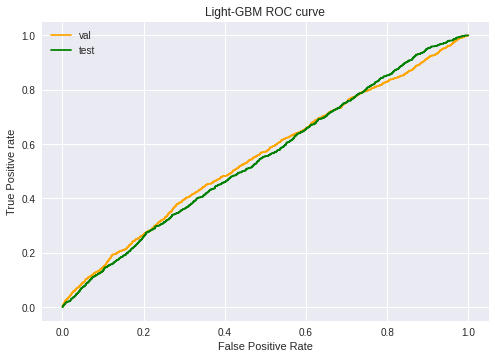

In [ ]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_val, tpr_val, linestyle='-',color='orange', label='val')
plt.plot(fpr_test, tpr_test, linestyle='-',color='green', label='test')
# plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('Light-GBM ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
plt.show();

####SVM

In [ ]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_
#svm_clf = svc_param_selection(X_train_cv_mfcc,y_train_cv_mfcc,5)

In [ ]:
#svm_clf

In [38]:
svm_clf = svm.SVC(probability=True,kernel="rbf",C=1,gamma=0.001)
svm_clf.fit(X_train_cv, y_train_cv)

SVC(C=1, gamma=0.001, probability=True)

In [39]:
final_val = svm_clf.predict_proba(X_val_cv)
final_test = svm_clf.predict_proba(X_test_cv)

fpr_val, tpr_val, thresh_val = roc_curve(y_val_cv, final_val[:, 1], pos_label=1)
fpr_test, tpr_test, thresh_test = roc_curve(y_test_cv, final_test[:, 1], pos_label=1)

auc_val = roc_auc_score(y_val_cv, final_val[:, 1])
auc_test = roc_auc_score(y_test_cv, final_test[:, 1])

print(auc_val, auc_test)

0.5543095028377643 0.5359283627616104


In [ ]:
pickle.dump(svm_clf, open('/content/gdrive/MyDrive/Senior Thesis/Workspace/recognition/ml_model/saved_model/svm_'+ver+'.pkl', 'wb'))

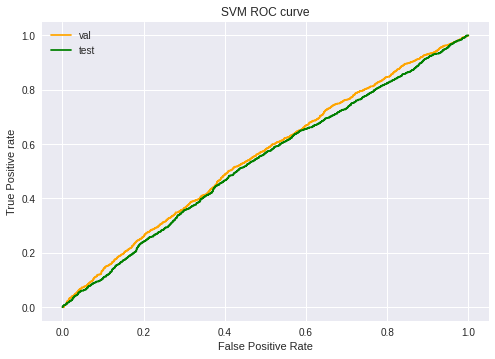

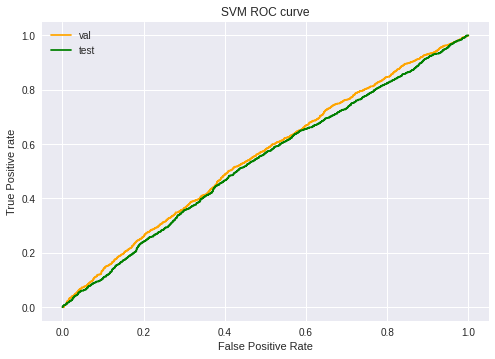

In [41]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_val, tpr_val, linestyle='-',color='orange', label='val')
plt.plot(fpr_test, tpr_test, linestyle='-',color='green', label='test')
# plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('SVM ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
plt.show();

###Catboost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
#models=[]
#for seed in seeds:
#    final_test = np.zeros(X_test.shape[0])
#    final_val = np.zeros(X_val.shape[0])
#    logger.info(f'----------- seed: {seed} -----------')
#    kfolds = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)
#    for trn_ind, val_ind in kfolds.split(X=X_train, y=y_train):
#        kf_x_train, kf_y_train = X_train[trn_ind], y_train[trn_ind]
#        kf_x_valid, kf_y_valid = X_train[val_ind], y_train[val_ind]
#        model = CatBoostClassifier(
#            iterations = 1000,
#            depth = 8,
#            verbose = 100,
#            learning_rate = 0.03
#        )
#        model.fit(X_train, y_train, eval_set=(kf_x_valid, kf_y_valid))
#        models.append(model)
#        y_pred = model.predict(X_test)
#        print("ACC: ",accuracy_score(y_test, y_pred))
#        print("AUC:",roc_auc_score(y_test_cv,model.predict_proba(X_test_cv)[:,1]))

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
model = CatBoostClassifier(
            iterations = 1000,
            depth = 8,
            verbose = 100,
            learning_rate = 0.03
        )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("ACC: ",accuracy_score(y_test, y_pred))
print("AUC:",roc_auc_score(y_test_cv,model.predict_proba(X_test_cv)[:,1]))

0:	learn: 0.6919719	total: 219ms	remaining: 3m 39s
100:	learn: 0.6366486	total: 13.9s	remaining: 2m 3s
200:	learn: 0.6065296	total: 23.5s	remaining: 1m 33s
300:	learn: 0.5824835	total: 29.3s	remaining: 1m 7s
400:	learn: 0.5602772	total: 35s	remaining: 52.4s
500:	learn: 0.5381118	total: 40.8s	remaining: 40.7s
600:	learn: 0.5187564	total: 46.6s	remaining: 31s
700:	learn: 0.5002729	total: 52.5s	remaining: 22.4s
800:	learn: 0.4825919	total: 58.3s	remaining: 14.5s
900:	learn: 0.4663399	total: 1m 4s	remaining: 7.05s
999:	learn: 0.4509172	total: 1m 10s	remaining: 0us
ACC:  0.5989465763732129
AUC: 0.6422573262777969


###RF

In [ ]:
########## Tuned Random Forest #######
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier 
model = RandomForestClassifier(
    n_estimators = 1000, 
    #criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = 'True', # more on this below
    random_state=69  
) 

model.fit(X_train_cv, y_train_cv)

#print(f'Random Forest Model\'s accuracy on training set is {100*model.score(X_train_cv, y_train_cv):.2f}%')
#print(f'Random Forest Model\'s accuracy on test set is {100*model.score(X_test_cv, y_test_cv):.2f}%')
m1 = tf.keras.metrics.AUC()
m1.update_state(y_test_cv, model.predict_proba(X_test_cv)[:,1])
#roc_auc_score(y_test_cv,model.predict(X_test_cv))
print('AUC={}'.format(m1.result().numpy())) 

AUC=0.5533979535102844


In [ ]:
pickle.dump(model, open('/content/gdrive/MyDrive/Senior Thesis/Workspace/recognition/ml_model/saved_model/rf_'+ver+'.pkl', 'wb'))